# Toxic Comment challenge
This is an NLP based binary classification problem. I plan to use a variety of approaches to solve the problem ranging from classical methods to more advance deep learning based methods. My primary objective is to learn how to efficiently represent text in a form amenable to application of ML techniques. Some of the methods I explore are - 

1. Bag of words
2. TF-IDF vectors
3. Using pre-Learned word Embeddings - GLOVE
4. Effectively using GLOVE for paragraph representations

The data set used is from a challenge hostedon kaggle by google. The data set contains a large number of user comments that have been labeled(binary) by humans for toxic behaviour. The objective is to learn a model from this labelled data that can identify toxic behaviour in commnet text.

## EDA

In [298]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

all_data = pd.read_csv("train.csv")

all_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


- The 'id' column is a unique id identifying each row - this will not contribute to our model.
- 'comment_text'is the actual text of the comment - the meat of the problem.
- The rest of the the 6 columns are the tags that each identify wheater the 'comment_text' beongs to that category. For now, the only column of concern is the 'toxic' column

The task is to build a model that given a comment can identify if it falls into the category 'toxic' or not.

In [299]:
all_data.iloc[:,2:7].sum(axis = 0)/all_data.shape[0]

toxic           0.095844
severe_toxic    0.009996
obscene         0.052948
threat          0.002996
insult          0.049364
dtype: float64

Another interesting thing to note is that there are relatively few instances of toxic comments under each category. This indicates a class imblalance -something that needs to be kept in mind while building and evaluating the classification model.

There may be interesting relations between the multiple independednt binary variables. Below I explore the similarity of the catogories in the train data using Jaccards coefficient - a simple metric to calculated similarity between binary varibles.

In [300]:
def cumpute_jaccard(x,y):
    count_df= pd.crosstab(x, y)
    jaccard = count_df.iloc[1,1] / ( count_df.iloc[0,1] +  count_df.iloc[1,1] + count_df.iloc[1,0])
    return jaccard

In [301]:
all_data.iloc[:,2:7].corr(method = cumpute_jaccard)


,toxic,severe_toxic,obscene,threat,insult
toxic,1.000000,0.104289,0.501106,0.029302,0.464017
severe_toxic,0.104289,1.000000,0.177905,0.057114,0.169238
obscene,0.501106,0.177905,1.000000,0.034895,0.605152
threat,0.029302,0.057114,0.034895,1.000000,0.038146
insult,0.464017,0.169238,0.605152,0.038146,1.000000


There are some significant overlaps between the categories for sure. We may be able to build a better model if we take these overlaps into consideration. However, for now, I will ignore these and focus on building a model to identify 'toxic' comments.

## Linear model to predict 'toxic' variable

Starting simple. Fit a linear model to the comment text to predict the target binary variable 'toxic'.

### Cleaning the text data

1. Remove all punctuations (may be revisited because certain puctuations !,# might be helful to identify toxic behavior)
2. Remove all non-alphabet info - likely will not be useful. For typos and non-english text - i will remove rarely occuring words in corpus during training.


In [302]:
"---".join(all_data['comment_text'][1:5])

'D\'aww! He matches this background colour I\'m seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)---Hey man, I\'m really not trying to edit war. It\'s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.---"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "---You, sir, are

In [303]:
# Cleaning the data
import re

def clean_text(text):
    text_clean = re.sub( "[/(){}\[\]\|@,;:\n]" , " " ,text.lower()) ## replace punctuation by space
    text_clean = re.sub( "[^a-zA-Z\s:]" , "" ,text_clean) ## retain only text - remove all other charecters
    return text_clean

all_data['clean_comment_text'] = [clean_text(x) for x in all_data['comment_text']]


In [304]:
# Splitting training and testing data at this point, 80:20

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state = 1)

y_train = train_data['toxic']
y_test = test_data['toxic']

#### Word Count analysis

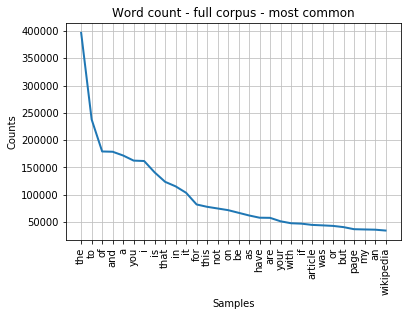

In [305]:
import nltk, itertools
tokenizer = nltk.tokenize.WhitespaceTokenizer()
fdist = nltk.FreqDist(list(itertools.chain.from_iterable([tokenizer.tokenize(x) for x in train_data['clean_comment_text']])))
fdist.plot(30 , cumulative=False , title = "Word count - full corpus - most common")



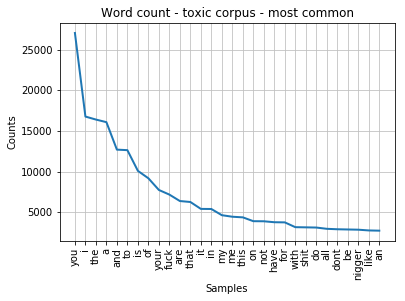

In [306]:
fdist = nltk.FreqDist(list(itertools.chain.from_iterable([tokenizer.tokenize(x) for x in train_data['clean_comment_text'][train_data['toxic']==1]])))
fdist.plot(30 , cumulative=False , title = "Word count - toxic corpus - most common")

In [307]:
# Least common words
fdist.most_common()[-50:]

[('elyrian', 1),
 ('unhurt', 1),
 ('meggie', 1),
 ('everett', 1),
 ('engineer', 1),
 ('subjected', 1),
 ('dealwrongdoing', 1),
 ('ponpon', 1),
 ('wrecking', 1),
 ('tanthony', 1),
 ('sandchigger', 1),
 ('juppiter', 1),
 ('escorrt', 1),
 ('caty', 1),
 ('yrgh', 1),
 ('snowfire', 1),
 ('vandalizer', 1),
 ('pleasedontdeletemyedits', 1),
 ('geographical', 1),
 ('hounded', 1),
 ('passiveaggressive', 1),
 ('peons', 1),
 ('wwthevergecom', 1),
 ('whyareeditorsleavingtheworldsbiggestencyclopedia', 1),
 ('parks', 1),
 ('warts', 1),
 ('fuku', 1),
 ('perpetual', 1),
 ('fountains', 1),
 ('edisontechcentercom', 1),
 ('xck', 1),
 ('spk', 1),
 ('changer', 1),
 ('meaningfulmeaning', 1),
 ('iti', 1),
 ('reddish', 1),
 ('aryour', 1),
 ('ticle', 1),
 ('redrose', 1),
 ('satin', 1),
 ('trevor', 1),
 ('tred', 1),
 ('oooooooooooooooooooooooooooo', 1),
 ('ooooooooooooooooooooooooooooooooooooooooooooooooooooo', 1),
 ('scoobydoo', 1),
 ('greekwarrior', 1),
 ('mysterion', 1),
 ('clyde', 1),
 ('concise', 1),
 ('pseu

As expected stop words are the most common in the whole corpus and even in the 'toxic' corpus. Also, typos and namedreferences are among the most infrequently accuring words. While training model, we will take care to exclude both these classes of words.

### Bag of words

In [308]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizerBow = CountVectorizer(ngram_range=(1,2), stop_words = 'english',max_features =5000, min_df = 50 , max_df = 0.99)

X_train_bow = vectorizerBow.fit_transform(train_data['clean_comment_text'])
X_test_bow = vectorizerBow.transform(test_data['clean_comment_text'])

feature_names_bow = vectorizerBow.get_feature_names()


In [309]:
def fitAndTestmodel(X_train , X_test, y_train, y_test):
    logregModel = LogisticRegression(penalty = 'l2' , C = 1)
    logregModel.fit(X_train,y_train)
    predicted_y_test = logregModel.predict_proba(X_test)
    rocauc = roc_auc_score(y_test ,predicted_y_test[:,1] )
    print("ROC AUC Score -" ,rocauc)
    return 

In [310]:
fitAndTestmodel(X_train_bow , X_test_bow , y_train, y_test)


ROC AUC Score - 0.9448415722152508


In [311]:
# Get most important features

def printImportantFeatures(X_train,y_train,feature_names):
    X_kbest = fvalue_selector.fit_transform(X_train, y_train)
    feature_names.__len__()
    y = fvalue_selector.get_support()
    important_features = [x for x,i in zip(feature_names,y) if i]
    print("Most important features :" , ",".join(important_features))
    return

printImportantFeatures(X_train_bow,y_train , feature_names_bow)

Most important features : article,cock,crap,fucked,fucking,idiots,motherfucker,prick,retard,ur


### TF-IDF vectors

In [312]:
from sklearn.feature_extraction.text import TfidfVectorizer

# using 1 and 2 grams of words
# uning l2 normalisation for feature vector of each document
# removing stopwords
# setting a cap on max features to speed up process and avoid over - fitting
# removing too rarely occuring words which are probably typos or named references

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), norm='l2', stop_words = 'english',max_features =5000, min_df = 50 , max_df = 0.99 ) 

X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['clean_comment_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['clean_comment_text'])

In [313]:
feature_names_tfidf = tfidf_vectorizer.get_feature_names()

### Fit logistic model

In [314]:
fitAndTestmodel(X_train_tfidf , X_test_tfidf , y_train, y_test)

printImportantFeatures(X_train_tfidf,y_train , feature_names_tfidf)

ROC AUC Score - 0.9614729260004594
Most important features : ass,asshole,bitch,dick,fuck,fucking,idiot,shit,stupid,suck


Our relatively simple model using basic tf-idf features does well. Also note that among the 10 most important features - all are words that are umm... toxic. This demostrates why it is a better approach that bow.

The model does well also perhaps because the mere presence of certain unigrams correlates very well with the cooment being toxic - something that might not work if the information we needed was much more subtle. It would be interesting to see if learning dense vector representations ccould improve this performance.

### GLOVE features

Now let's try using the hard work of the good people at Stanford. They have made available vector reprenstations of words - which have been learned in an unsupervised way over a large corpus. 

In [315]:
## Tokenizing uning previously used whitespace tokenizer from nltk
train_data['clean_comment_text_tokenized'] = [tokenizer.tokenize(x) for x in train_data['clean_comment_text']]
test_data['clean_comment_text_tokenized'] = [tokenizer.tokenize(x) for x in test_data['clean_comment_text']]

In [316]:
import gensim

In [317]:
#from gensim.scripts.glove2word2vec import glove2word2vec
#glove_input_file = 'glove.6B.100d.txt'
#word2vec_output_file = 'word2vec.txt'
#glove2word2vec(glove_input_file, word2vec_output_file)

In [318]:
# Loading the glove model from disk
from gensim.models import KeyedVectors
filename = 'word2vec.txt' #dowloaded model file - converted into word2vec format
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False) #load glove model into RAM

In [319]:
glove_vocab = glove_model.vocab
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def getGloveVector(sentence , model , vocab):
    sentence = [x for x in sentence if x in vocab and x not in stop_words ] ## remove words not in dictionary and stop words
    gv = np.zeros((1,100))
    if(sentence.__len__() > 0):
        gv = model.wv[sentence].sum(axis = 0)
    return gv

print("The vector representation for 'the cat sat on the mat' is - \n",getGloveVector( ['the', 'cat','sat', 'on','the', 'mat', ] , glove_model , glove_vocab )) 

The vector representation for 'the cat sat on the mat' is - 
 [-7.7008998e-01  1.2073100e+00  8.5778999e-01 -1.6087000e+00
 -1.5735201e+00  2.0247800e+00 -1.9553199e-01  1.2699299e+00
 -7.3517299e-01 -1.5889711e+00  8.3257002e-01  6.3399598e-04
  1.1765200e+00  2.2569002e-01  1.6922300e+00  4.9297997e-01
  4.3902999e-01  8.0958605e-01 -1.8552998e-01 -1.7070899e+00
  1.3461000e-01  1.2771699e+00  6.0156101e-01 -7.5835001e-01
  1.9741200e+00  1.5423601e+00 -1.0521600e+00 -1.1438490e+00
 -4.0687019e-01  2.0985001e-01 -1.7286998e-01  6.6258156e-01
  7.0366597e-01  3.7584999e-01  5.8648002e-01  1.2335500e+00
 -2.1295300e-01  1.9678899e+00  1.0941401e+00 -5.8835000e-01
 -6.0928005e-01  8.7169021e-02  9.8383999e-01 -1.5329900e+00
 -5.7173002e-01  1.5954000e-01 -2.5162599e+00  1.5406300e+00
  8.1229001e-01 -6.8897325e-01 -1.1576816e+00 -4.9469000e-01
  3.9929998e-01  2.5583701e+00 -1.0256200e+00 -3.0744500e+00
 -4.1704601e-01  7.0223999e-01  1.7904699e+00  5.0038999e-01
  1.0677600e+00  1.6058

In [320]:

def getGloveMatrix( corpus ,glove_model ,glove_vocab  ):
    y = [getGloveVector(x , glove_model ,glove_vocab ) for x in corpus] # get vec representation for each sentence
    X_glove = np.zeros(( corpus.shape[0] ,100))
    for i in range(corpus.shape[0]):
        X_glove[i,:] = y[i]
        X_glove[i,:] = X_glove[i,:]/(np.linalg.norm(X_glove[i,:] , ord =2) + 1e-4) # normalize each text vector
    return X_glove

In [321]:
X_train_glove = getGloveMatrix(train_data['clean_comment_text_tokenized'] , glove_model , glove_vocab)
X_test_glove = getGloveMatrix(test_data['clean_comment_text_tokenized'] , glove_model , glove_vocab)

In [322]:
fitAndTestmodel(X_train_glove , X_test_glove , y_train, y_test)

ROC AUC Score - 0.9336660927302777


It seems like the performance is subpar compared to out tf-idf vectors. However, we use significantly less number of features - only 100. To get performance that is comparable - we have to use 1000 tf-idf features.
Using higher dimentional word embeddings will probably make a better model.

### Hybrid approach - word vectors weighted by tifidf vectors
So far - to get the glove embedding of a certain chunk of text - I have been adding the vector represntations of all words(which are also in the GOLVE vocab) in the text - . There are a couple of ways I think this could be made more efficient - 

1. Removing stop words and rare or infrequent words
2. instead of adding word representatios of all words - use the TF-idf vector to weight the contribution of each word. This way - words with high tf-idf values for a certain text - have higher weight in the dense vector representation.


In [323]:
y = [i for i in range(feature_names.__len__()) if feature_names[i] in glove_vocab]
print( y.__len__() ,"out of 5000 most common corpus words(excluding stop words and too frequent words) in glove vocab" )

4023 out of 5000 most common corpus words(excluding stop words and too frequent words) in glove vocab


In [324]:
feature_names_gloveP = [feature_names[x] for x in y]
word_vec_features = glove_model.wv[feature_names_gloveP]
text_word_tfidf = X_train_tfidf[:,y]

X_train_tfidf_glove = text_word_tfidf*word_vec_features
X_test_tfidf_glove = X_test_tfidf[:,y]*word_vec_features

In [325]:
fitAndTestmodel(X_train_tfidf_glove , X_test_tfidf_glove , y_train, y_test)

ROC AUC Score - 0.9279955739160318


The Tfidf weighted word vectors were not as effective as weights for glove word vectors. 

### A summary of results so far
| Features | AUC ROC | feature dimentionality |
| --- | --- | --- |
| Bag of words |  0.944 | 5000 |
| Tfidf vectors |  0.961 | 5000 |
| Glove  |  0.933  | 100 |
| Tfidf weighted Glove |  0.927 | 100 |